<a href="https://colab.research.google.com/github/JohnWangDataAnalyst/ADNI3_PIPELINE_Baycrest_grid/blob/master/PPMI_modelfitting_postanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
%cd /content/drive/MyDrive/Work/Sciencing/pyls/

/content/drive/MyDrive/Work/Sciencing/pyls


In [ ]:
! pwd
!vim pyls_test/examples/datasets.py

/content/drive/MyDrive/Work/Sciencing/pyls
/bin/bash: vim: command not found


In [ ]:
! python setup.py install

running install
running bdist_egg
running egg_info
writing pyls.egg-info/PKG-INFO
writing dependency_links to pyls.egg-info/dependency_links.txt
writing requirements to pyls.egg-info/requires.txt
writing top-level names to pyls.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'pyls.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/lib/pyls_test
copying pyls_test/__init__.py -> build/lib/pyls_test
copying pyls_test/_version.py -> build/lib/pyls_test
copying pyls_test/io.py -> build/lib/pyls_test
copying pyls_test/structures.py -> build/lib/pyls_test
copying pyls_test/utils.py -> build/lib/pyls_test
copying pyls_test/base.py -> build/lib/pyls_test
copying pyls_test/compute.py -> build/lib/pyls_test
creating build/lib/pyls_test/examples
copying pyls_test/examples/__init__.py -> build/lib/pyls_test/examples
copying pyls_test/examples/datasets.py -> build/lib/pyls_test/example

In [ ]:
! git clone https://github.com/rmarkello/pyls.git

Cloning into 'pyls'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 1649 (delta 1), reused 2 (delta 0), pack-reused 1642
Receiving objects: 100% (1649/1649), 4.98 MiB | 7.07 MiB/s, done.
Resolving deltas: 100% (1073/1073), done.


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! ls /content/drive/MyDrive/Work/Sciencing/Data/PPMI/

pls_onsc_fc_scmod.png		    PPMI_hist_modelweights_203.png
PPMICON_NC_corr_modelparas+fit.png  PPMI_hist_modelweights_204.png
PPMICON_NC_hist_FCs.png		    PPMI_hist_modelweights_205.png
PPMI_CON_NC_hist_modelparas.png     PPMI_hist_modelweights_206.png
PPMI_corr_modelparas+fit.png	    PPMI_hist_modelweights_207.png
PPMI_hist_modelparas.png	    PPMI_hist_modelweights_208.png
PPMI_hist_modelweights_0.png	    PPMI_hist_modelweights_209.png
PPMI_hist_modelweights_100.png	    PPMI_hist_modelweights_20.png
PPMI_hist_modelweights_101.png	    PPMI_hist_modelweights_210.png
PPMI_hist_modelweights_102.png	    PPMI_hist_modelweights_211.png
PPMI_hist_modelweights_103.png	    PPMI_hist_modelweights_212.png
PPMI_hist_modelweights_104.png	    PPMI_hist_modelweights_213.png
PPMI_hist_modelweights_105.png	    PPMI_hist_modelweights_214.png
PPMI_hist_modelweights_106.png	    PPMI_hist_modelweights_215.png
PPMI_hist_modelweights_107.png	    PPMI_hist_modelweights_216.png
PPMI_hist_modelweights_108.png	  

In [5]:
base_dir = '/content/drive/MyDrive/Work/Sciencing/Data/PPMI/'
ppmi_file = base_dir+'PPMI_WWD_model_fitting.npy'





In [6]:
ppmi_data = np.load(ppmi_file, allow_pickle=True)


In [7]:
ppmi = ppmi_data.item()
ppmi_CON_NC_fc = ppmi['CON_NC']['fc']
ppmi_CON_NC_sc = ppmi['CON_NC']['sc']
ppmi_CON_NC_fc_sim = ppmi['CON_NC']['fc_sim']
ppmi_CON_NC_sc_mod = ppmi['CON_NC']['sc_mod']
ppmi_CON_NC_para = ppmi['CON_NC']['para']

ppmi_PD_NC_fc = ppmi['PD_NC']['fc']
ppmi_PD_NC_sc = ppmi['PD_NC']['sc']
ppmi_PD_NC_fc_sim = ppmi['PD_NC']['fc_sim']
ppmi_PD_NC_sc_mod = ppmi['PD_NC']['sc_mod']
ppmi_PD_NC_para = ppmi['PD_NC']['para']

In [8]:
groups =['CON_NC', 'PD_NC','PRO_NC']#['PD_D', 'CON_NC', 'CON_MCI', 'PRO_MCI', 'PRO_NC', 'PD_NC']

In [ ]:
import os, sys
sys.path.append(os.getcwd())

In [ ]:
from pyls_test.plotting.meancentered import plot_contrast
from pyls_test.types.meancentered import meancentered_pls

In [ ]:
def pre_PLS_getMasks(var_ind):
  pls_variables=['sc', 'fc', 'sc_mod']
  mask = np.tril_indices(96,-1)
  mask2=np.array([True]*4560)
  weights = np.zeros((4560))
  con_network = np.zeros((96,96))
  for k in range(3):
    data = []
    group_infos = []
    num_subs_train = [23,65, 15]

    
    subs_no_train={}
    j = 0
    for  grp in groups:
      subs_no_train[grp]=[]
      group_infos.append(len(ppmi[grp]['sc']))
      subs_order=np.random.choice(group_infos[j], num_subs_train[j], replace=False)
      i=0
      for sub in ppmi[grp]['sc']:
        if i in subs_order:
          data_sub = []
          
          sc_mod = ppmi[grp][pls_variables[var_ind]][sub]
          data_sub.extend(list(sc_mod.copy()[mask])) #[mask2]
          data.append(data_sub)
          i+=1
        else:
          subs_no_train[grp].append(sub)
          i+=1
      j += 1

    data = np.array(data)
    mpls_scmod_pre = meancentered_pls(data , mean_centering=1, n_perm=5000, n_boot=5000, groups= num_subs_train, n_cond=1)


    mask2 = mask2*(np.abs(mpls_scmod_pre.bootres.x_weights_normed[:,0]) > 2.38)

  weights[mask2] =  (mpls_scmod_pre.bootres.x_weights_normed[:,0][mask2])
  con_network[mask] = weights
  #print(mpls_scmod_pre.bootres.x_weights_normed[:,0][mask2])
  return mask2, con_network


In [ ]:
def train_test_getAccuracy(var_ind, mask2):
  mask = np.tril_indices(96,-1)
  pls_variables=['sc', 'fc', 'sc_mod']
  accuracy_pred={}
  accuracy_pred['CON_NC']=[]
  accuracy_pred['PD_NC']=[]
  accuracy_pred['PRO_NC']=[]
  accuracy_recall={}
  accuracy_recall['CON_NC']=[]
  accuracy_recall['PD_NC']=[]
  accuracy_recall['PRO_NC']=[]



  for k in range(10):
    data = []
    group_infos = []

    num_subs_train = [13,35, 10]
    subs_no_train={}
    j = 0
    for  grp in groups:
      subs_no_train[grp]=[]
      group_infos.append(len(ppmi[grp]['sc']))
      subs_order=np.random.choice(group_infos[j], num_subs_train[j], replace=False)
      i=0
      for sub in ppmi[grp]['sc']:
        if i in subs_order:
          data_sub = []
          """para = ppmi[grp]['para'][sub][-10:,:4].mean(0)
          data_sub.extend(list(para.copy()))"""
          sc_mod = ppmi[grp][pls_variables[var_ind]][sub]
          data_sub.extend(list(sc_mod.copy()[mask][mask2])) #[mask2]
          data.append(data_sub)
          i+=1
        else:
          subs_no_train[grp].append(sub)
          i+=1
      j += 1

    data = np.array(data)
    mpls_scmod = meancentered_pls(data , mean_centering=1, n_perm=1000, n_boot=100, groups= num_subs_train, n_cond=1)

    centers = np.zeros((3,3))

    centers[0,:] = mpls_scmod.x_scores[:num_subs_train[0]].mean(0)
    centers[1, :] = mpls_scmod.x_scores[num_subs_train[0]:num_subs_train[0]+num_subs_train[1]].mean(0)
    centers[2,:] = mpls_scmod.x_scores[num_subs_train[0]+num_subs_train[1]:sum(num_subs_train)].mean(0)
    
    pred_num={}
    pred_num['PD_NC']=0
    pred_num['CON_NC']=0
    pred_num['PRO_NC']=0
    for i, grp in enumerate(groups):
      num_correct = 0
      
      for sub in subs_no_train[grp]:
        x_scores = (ppmi[grp][pls_variables[var_ind]][sub][mask][mask2]).dot(mpls_scmod.x_weights)
        pred_num[groups[np.argmin(((centers - x_scores)**2).sum(1))]] += 1
        if i == np.argmin(((centers - x_scores)**2).sum(1)):
          num_correct += 1
          
      accuracy_pred[grp].append(num_correct/(group_infos[i] - num_subs_train[i]))
    for i, grp in enumerate(groups):
      accuracy_recall[grp].append(accuracy_pred[grp][-1]*(group_infos[i] - num_subs_train[i])/pred_num[grp])

    return accuracy_pred, accuracy_recall


In [ ]:
# : 0 sc 1 fc 2 sc_mod
mask2 = pre_PLS_getMasks(0)

accuracy_pred, accuracy_recall = train_test_getAccuracy(0, mask2)

In [ ]:
centers = np.zeros((96,3))
for i in range(3):
  mask2, con_network = pre_PLS_getMasks(i)
  U, s, V =np.linalg.svd(con_network + con_network.T)
  centers[:,i] = U[:,0]
print(s)
centers

[1.71031512e+01 1.53021940e+01 1.34079558e+01 1.24897433e+01
 1.17843995e+01 1.13847564e+01 1.03165967e+01 1.02005122e+01
 1.01128557e+01 9.58948102e+00 9.07997203e+00 8.68865602e+00
 8.56075711e+00 7.99703679e+00 7.87965845e+00 7.75733880e+00
 7.40508677e+00 7.24486532e+00 7.13721293e+00 7.04163799e+00
 7.04082752e+00 6.79565065e+00 6.68691143e+00 6.43392272e+00
 6.22012274e+00 6.19702579e+00 6.04131362e+00 5.92479988e+00
 5.74085426e+00 5.63107564e+00 5.44932032e+00 5.37875883e+00
 5.25753220e+00 5.16465528e+00 5.12724923e+00 4.97561243e+00
 4.81794457e+00 4.79372381e+00 4.62755222e+00 4.53369687e+00
 4.36853165e+00 4.32202660e+00 4.22166011e+00 4.08020346e+00
 4.03264546e+00 3.92894094e+00 3.66585246e+00 3.40685451e+00
 3.38896028e+00 3.26919933e+00 3.17712835e+00 2.95678080e+00
 2.90151785e+00 2.85146879e+00 2.73229207e+00 2.63796022e+00
 2.61926020e+00 2.53940038e+00 2.51149613e+00 2.40845181e+00
 2.21961017e+00 2.13019677e+00 2.10540266e+00 1.97598712e+00
 1.78263175e+00 1.778443

array([[ 9.20956492e-03, -1.12798624e-01, -1.12463576e-01],
       [ 1.24486132e-01, -1.03249662e-01, -2.77966849e-01],
       [ 4.86081683e-02, -2.52275041e-02, -3.47832898e-02],
       [ 5.01407137e-03, -1.04103817e-01, -1.75662250e-01],
       [ 5.10760648e-02, -2.29854442e-01, -1.59406879e-01],
       [ 5.45003166e-02, -2.02334606e-02, -3.80714875e-02],
       [ 7.76572241e-02, -1.21211773e-01, -2.71449634e-02],
       [ 2.18132057e-01, -7.28325383e-02, -9.55704276e-02],
       [ 3.01860049e-02, -1.08041689e-01, -2.17918954e-02],
       [ 2.42689369e-02, -1.44431855e-01, -1.46512723e-02],
       [ 7.62318829e-02, -6.91758362e-02, -2.08369910e-01],
       [ 2.35880024e-01, -1.19190556e-01, -3.23002945e-02],
       [-1.03397577e-25, -8.37407260e-02, -6.27677250e-02],
       [ 6.57602237e-02, -1.96752532e-01, -4.31451982e-01],
       [ 7.69365390e-02, -1.20370622e-35,  3.05779657e-03],
       [ 5.93782882e-02, -8.16638204e-02, -1.60124841e-01],
       [ 2.75781280e-02, -2.34974921e-02

In [ ]:
s

array([1.71031512e+01, 1.53021940e+01, 1.34079558e+01, 1.24897433e+01,
       1.17843995e+01, 1.13847564e+01, 1.03165967e+01, 1.02005122e+01,
       1.01128557e+01, 9.58948102e+00, 9.07997203e+00, 8.68865602e+00,
       8.56075711e+00, 7.99703679e+00, 7.87965845e+00, 7.75733880e+00,
       7.40508677e+00, 7.24486532e+00, 7.13721293e+00, 7.04163799e+00,
       7.04082752e+00, 6.79565065e+00, 6.68691143e+00, 6.43392272e+00,
       6.22012274e+00, 6.19702579e+00, 6.04131362e+00, 5.92479988e+00,
       5.74085426e+00, 5.63107564e+00, 5.44932032e+00, 5.37875883e+00,
       5.25753220e+00, 5.16465528e+00, 5.12724923e+00, 4.97561243e+00,
       4.81794457e+00, 4.79372381e+00, 4.62755222e+00, 4.53369687e+00,
       4.36853165e+00, 4.32202660e+00, 4.22166011e+00, 4.08020346e+00,
       4.03264546e+00, 3.92894094e+00, 3.66585246e+00, 3.40685451e+00,
       3.38896028e+00, 3.26919933e+00, 3.17712835e+00, 2.95678080e+00,
       2.90151785e+00, 2.85146879e+00, 2.73229207e+00, 2.63796022e+00,
      

In [ ]:
np.savetxt(base_dir+"eigenvector_sig_brainnetwork_SC_FC_SC_MOD.txt", centers)

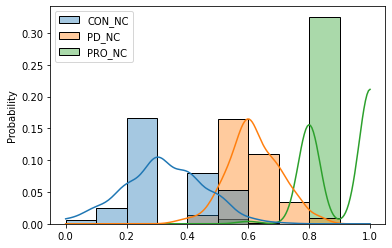

In [ ]:
accuracy_pred_sc = accuracy_pred.copy()
np.save(base_dir+'prediction_accuracy_sc.npy', accuracy_pred_sc)
sns.histplot(data = pd.DataFrame(accuracy_pred_sc), alpha =0.4, bins =0.1*np.arange(10), stat='probability', kde=True) #sc precision

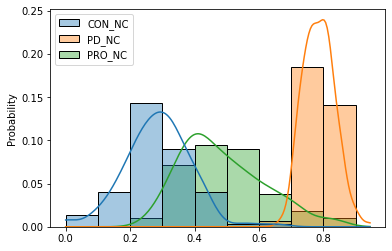

In [ ]:
accuracy_recall_sc = accuracy_recall.copy()
np.save(base_dir+'recall_accuracy_sc.npy', accuracy_recall_sc)
sns.histplot(data = pd.DataFrame(accuracy_recall_sc), alpha =0.4, bins =0.1*np.arange(10), stat='probability', kde=True) #sc recall

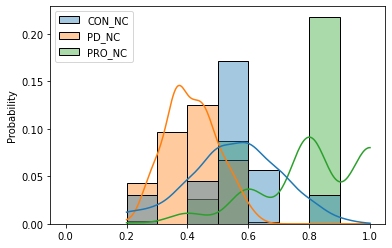

In [ ]:
accuracy_pred_fc = accuracy_pred.copy()
#np.save(base_dir+'prediction_accuracy_fc.npy', accuracy_pred_fc)
sns.histplot(data = pd.DataFrame(accuracy_pred_fc), alpha =0.4, bins = 0.1*np.arange(10), stat='probability', kde= True) #fc precision

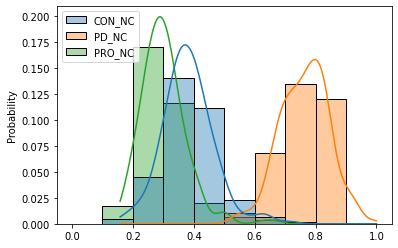

In [ ]:
accuracy_recall_fc = accuracy_recall.copy()
#np.save(base_dir+'recall_accuracy_fc.npy', accuracy_recall_fc)
sns.histplot(data = pd.DataFrame(accuracy_recall_fc), alpha =0.4, bins =0.1*np.arange(10), stat='probability', kde=True)  #fc recall

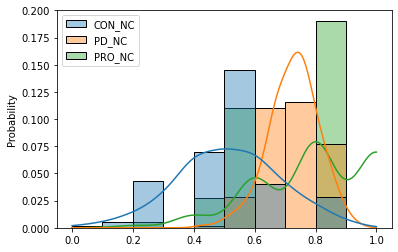

In [ ]:
#accuracy_pred_scmod = accuracy_pred.copy()
#np.save(base_dir+'prediction_accuracy_scmod.npy', accuracy_pred_scmod)
sns.histplot(data = pd.DataFrame(accuracy_pred_scmod), alpha =0.4, bins = 0.1*np.arange(10), stat='probability', kde=True) #presicion sc_mod

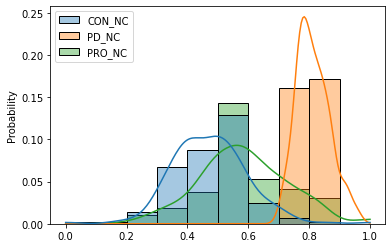

In [ ]:
#accuracy_recall_scmod = accuracy_recall.copy()
#np.save(base_dir+'recall_accuracy_scmod.npy', accuracy_recall_scmod)
sns.histplot(data = pd.DataFrame(accuracy_recall_scmod), alpha =0.4, bins =0.1*np.arange(10), stat='probability', kde=True)  #sc_mod recall

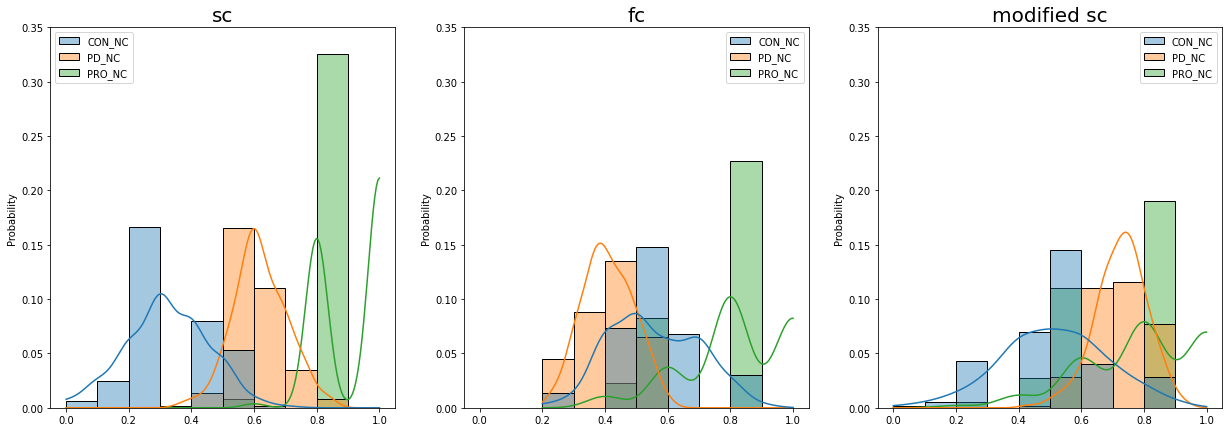

In [ ]:
fig, ax = plt.subplots(1,3, figsize= (21, 7))
sns.histplot(ax = ax[0], data = pd.DataFrame(accuracy_pred_sc), alpha =0.4, bins = 0.1*np.arange(10), stat='probability', kde= True)
sns.histplot(ax = ax[1], data = pd.DataFrame(accuracy_pred_fc), alpha =0.4, bins = 0.1*np.arange(10), stat='probability', kde= True)
sns.histplot(ax = ax[2], data = pd.DataFrame(accuracy_pred_scmod), alpha =0.4, bins = 0.1*np.arange(10), stat='probability', kde= True)
ax[0].set_ylim(0.0, 0.35)
ax[1].set_ylim(0.0, 0.35)
ax[2].set_ylim(0.0, 0.35)
ax[0].set_title('sc', fontsize='20')
ax[1].set_title('fc', fontsize='20')
ax[2].set_title('modified sc', fontsize='20')
plt.show()


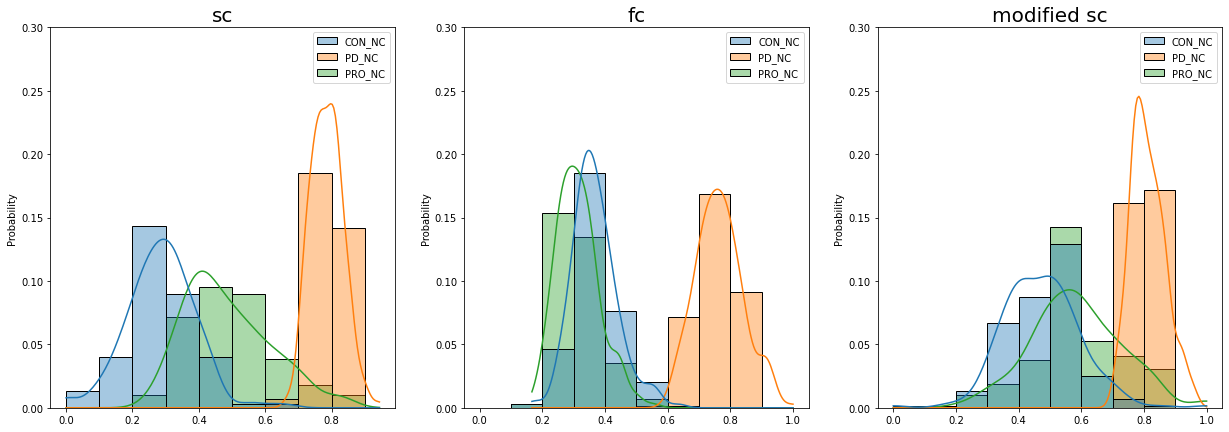

In [ ]:
fig, ax = plt.subplots(1,3, figsize= (21, 7))
sns.histplot(ax = ax[0], data = pd.DataFrame(accuracy_recall_sc), alpha =0.4, bins = 0.1*np.arange(10), stat='probability', kde= True)
sns.histplot(ax = ax[1], data = pd.DataFrame(accuracy_recall_fc), alpha =0.4, bins = 0.1*np.arange(10), stat='probability', kde= True)
sns.histplot(ax = ax[2], data = pd.DataFrame(accuracy_recall_scmod), alpha =0.4, bins = 0.1*np.arange(10), stat='probability', kde= True)
ax[0].set_ylim(0.0, 0.3)
ax[1].set_ylim(0.0, 0.3)
ax[2].set_ylim(0.0, 0.3)
ax[0].set_title('sc', fontsize='20')
ax[1].set_title('fc', fontsize='20')
ax[2].set_title('modified sc', fontsize='20')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,3, figsize= (21, 7))
sns.kdeplot(ax = ax[0], data = pd.DataFrame(accuracy_pred_sc))
sns.kdeplot(ax = ax[1], data = pd.DataFrame(accuracy_pred_fc))
sns.kdeplot(ax = ax[2], data = pd.DataFrame(accuracy_pred_scmod))
ax[0].set_ylim(0,1.8)
ax[1].set_ylim(0,1.8)
ax[2].set_ylim(0,1.8)
ax[1].set_xlim(0,1)
ax[2].set_xlim(0,1)
ax[0].set_xlim(0,1)
ax[0].set_title('sc', fontsize='20')
ax[1].set_title('fc', fontsize='20')
ax[2].set_title('modified sc', fontsize='20')
plt.show()

No handles with labels found to put in legend.


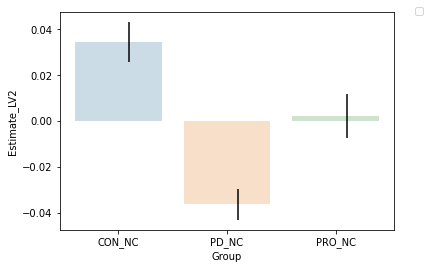

In [ ]:
plot_contrast(mpls_scmod_pre, lv=1, group_labels=groups)

In [ ]:
mpls_scmod_pre.permres.pvals

array([0.019996  , 0.04119176, 0.81123775])

In [ ]:
#fig, ax = plt.subplots(2,4, figsize=(12,8), sharey=True)
para_name = ['g', 'gEE', 'gIE', 'gEI', 'cA', 'cB', 'cC']
sns.barplot(x=para_name, y = mpls.bootres.x_weights_normed[:7,0])
    

In [ ]:
data_dict['group'].shape

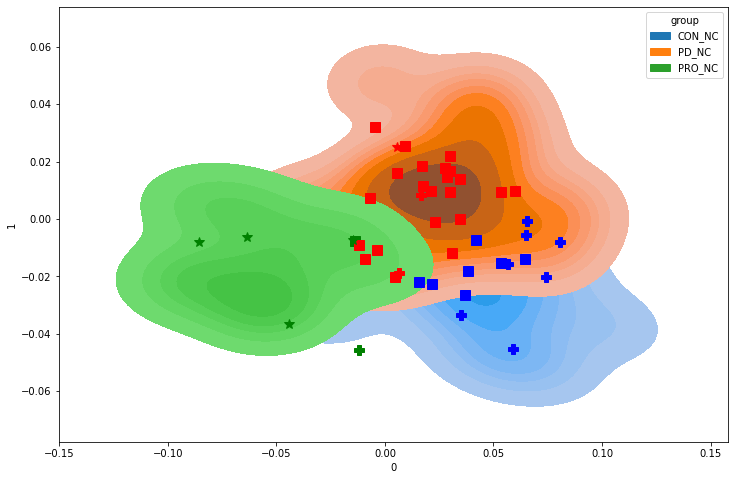

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
r_start=0
r_end = 0
start_ls = [0]
start_ls.extend(num_subs_train[:2])
grps = []
markers =['P', 's', '*']
for i, grp in enumerate(groups):
  ls_grp = []
  
  ls_grp.append(grp)
  ls_grp_sub = ls_grp * num_subs_train[i]
  grps.extend(ls_grp_sub)
data_dict ={}
data_dict['group'] = np.array(grps)
data_dict['0'] = mpls_scmod.x_scores[:,0]
data_dict['1'] = mpls_scmod.x_scores[:,1]
df = pd.DataFrame.from_dict(data_dict, orient='columns')
r_start += start_ls[i]
r_end += group_infos[i]
  
sns.kdeplot(data=df, x='0', y='1', hue='group', fill= True)
"""for i, grp in enumerate(groups):
  j = 0
  for sub in ppmi[grp]['sc_mod']:
    if j < num_subs_train[i]:
      x_scores = ppmi[grp]['sc_mod'][sub][mask][mask2].dot(mpls_scmod.x_weights)
      ax.plot(x_scores[0], x_scores[1], markers[i], color='black')
      

      j += 1
    else:

      j += 1"""
centers = np.zeros((3,3))

centers[0,:] = mpls_scmod.x_scores[:num_subs_train[0]].mean(0)
centers[1, :] = mpls_scmod.x_scores[num_subs_train[0]:num_subs_train[0]+num_subs_train[1]].mean(0)
centers[2,:] = mpls_scmod.x_scores[num_subs_train[0]+num_subs_train[1]:sum(num_subs_train)].mean(0)
cs =['b', 'r', 'g']
group_mean={}
group_mean['CON_NC'] = 0
group_mean['PD_NC'] = 0
group_mean['PRO_NC'] = 0


for i, grp in enumerate(groups):
  
  for sub in subs_no_train[grp]:
    x_scores = (ppmi[grp]['sc_mod'][sub][mask][mask2]).dot(mpls_scmod.x_weights)
    c = cs[np.argmin(((centers - x_scores)**2).sum(1))]
    
    ax.plot(x_scores[0], x_scores[1], markers[i], color=c, markersize=10)

    
plt.show()


In [ ]:
accuracy_pred

{'CON_NC': [0.8, 0.4, 0.5, 0.3, 0.6, 0.3, 0.5, 0.4, 0.3, 0.7],
 'PD_NC': [0.6333333333333333,
  0.7666666666666667,
  0.6666666666666666,
  0.8,
  0.7,
  0.7,
  0.7333333333333333,
  0.7,
  0.7666666666666667,
  0.7333333333333333],
 'PRO_NC': [0.6, 0.6, 1.0, 0.8, 1.0, 0.4, 1.0, 1.0, 0.8, 0.8]}

In [ ]:
mask2 = np.abs(mpls_scmod_pre.bootres.x_weights_normed[:,0]) > 2.5

In [ ]:

fig, ax = plt.subplots(1,1, figsize=(20,20))
mask = np.tril_indices(96,-1)
th = 2.5
s = 100*np.ones((96,96))
markers_ls=[]
X, Y = np.meshgrid(np.arange(96), np.arange(95,-1,-1))
for i in range(3):
  sc = np.zeros((96,96))
  if i == 0:
    sc[mask] = mpls_fc.bootres.x_weights_normed[:,0]
    sc = (sc+sc.T)
    sc[np.abs(sc)< th] = 0
    ax.scatter(X,Y, s=s, c=sc, alpha= .3, cmap='bwr', vmin = -1, vmax =1, marker='v')
    im, = ax.plot(0,95, 'v', color='b')
    markers_ls.append(im)
  elif i == 1:
    sc[mask] = mpls_sc.bootres.x_weights_normed[:,0]
    sc = (sc+sc.T)
    sc[np.abs(sc)< th] = 0
    ax.scatter(X,Y, s=s, c=sc, alpha= .3, cmap='bwr', vmin = -1, vmax =1, marker='<')
    im, = ax.plot(0,95, '<', color='b')
    markers_ls.append(im)
  else:
    sc[mask] = mpls_scmod.bootres.x_weights_normed[:,0]
    sc = (sc+sc.T)
    sc[np.abs(sc)< th] = 0
    ax.scatter(X,Y, s=s, c=sc, alpha= .3, cmap='bwr', vmin = -1, vmax =1, marker='>')
    im, = ax.plot(0,95, '>', color='b')
    markers_ls.append(im)
  ax.legend(markers_ls, ['fc', 'sc', 'sc_mod'])
  ax. plot(0,95, 's', color ='w')
  #im =ax.imshow(sc, cmap = 'bwr', vmin = -3.5, vmax =3.5, alpha = 0.2)
  #fig.colorbar(im, ax = ax, fraction = 0.046, pad = 0.04)
  ax.axis('off')
plt.show()
fig.savefig(base_dir+'pls_onsc_fc_scmod.png')

In [ ]:
mpls.bootres.x_weights_normed[:,2]

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(16,12))
j=0
for grp in groups:
  i=0
  for sub in ppmi[grp]['sc']:
      if i < 1:
          im0 = ax[j, 0].imshow(ppmi[grp]['sc'][sub], cmap='bwr')
          im1 = ax[j, 1].imshow(ppmi[grp]['fc'][sub], cmap='bwr')
          im2 = ax[j, 2].imshow(ppmi[grp]['fc_test'][sub], cmap='bwr')
          fig.colorbar(im0, ax = ax[j,0],  fraction = 0.046, pad = 0.04)
          fig.colorbar(im1, ax = ax[j,1],  fraction = 0.046, pad = 0.04)
          fig.colorbar(im2, ax = ax[j,2],  fraction = 0.046, pad = 0.04)
          ax[j,0].set_title(grp+ '_'+sub +': empirical SC')
          ax[j,1].set_title(grp+ '_'+sub +': empirical FC')
          ax[j,2].set_title(grp+ '_'+sub +' best fit: simulated FC')
          i += 1
      else:
          break
  j += 1
plt.show()
fig.savefig(base_dir+'PPMI_sc_fc_simfc_3subjects.png')

In [ ]:
fig, ax = plt.subplots(2,4, figsize=(15,8))
color_ls =['r', 'g', 'b']
for k, grp in enumerate(groups):
    
    HCP_para = ppmi[grp]['para']
    mask=np.tril_indices(96,-1)
    data_dict={}
    data_dict['g'] = []
    data_dict['gEE'] = []
    data_dict['gIE'] = []
    data_dict['gEI'] = []
    data_dict['cA'] = []
    data_dict['cB'] = []
    data_dict['cC'] = []
    para_name = ['g', 'gEE', 'gIE', 'gEI', 'cA', 'cB', 'cC']
    for sub in HCP_para:
        
        data_dict['g'].append(HCP_para[sub][-10:,0].mean())
        data_dict['gEE'].append(HCP_para[sub][-10:,1].mean())
        data_dict['gIE'].append(HCP_para[sub][-10:,2].mean())
        data_dict['gEI'].append(HCP_para[sub][-10:,3].mean())
        data_dict['cA'].append(HCP_para[sub][-10:,4].mean())
        data_dict['cB'].append(HCP_para[sub][-10:,5].mean())
        data_dict['cC'].append(HCP_para[sub][-10:,6].mean())
    data_dict['g'] = np.array(data_dict['g'])
    data_dict['gEE'] = np.array(data_dict['gEE'])
    data_dict['gIE'] = np.array(data_dict['gIE'])
    data_dict['gEI'] = np.array(data_dict['gEI'])
    data_dict['cA'] = np.array(data_dict['cA'])
    data_dict['cB'] = np.array(data_dict['cB'])
    data_dict['cC'] = np.array(data_dict['cC'])

    for i in range(7):
        sns.kdeplot(ax =ax[i//4, i%4], data= data_dict[para_name[i]], c =color_ls[k])
        ax[i//4, i%4].set_title('hist of ' + para_name[i] +' across subjects')
        ax[i//4, i%4].legend(groups)
plt.suptitle('PPMI dataset')
plt.show()
fig.savefig(base_dir+'PPMI_hist_modelparas.png')

In [ ]:
len(ind[0])//20

In [ ]:
ind = np.tril_indices(96,-1)
for j in range(len(ind[0])//20):
    
    fig, ax = plt.subplots(5,4, figsize=(15,18))
    color_ls =['r', 'g', 'b']

    for k, grp in enumerate(groups):
        
        
        mask=np.tril_indices(96,-1)
        data_dict ={}
        
        for i in range(20):
            name = str(ind[0][j*20+i])+ 'to'+str(ind[1][j*20+i])+' weight'
            #para_name.append(name)
            values = []
            for sub in ppmi[grp]['sc_mod']:
                
                values.append(ppmi[grp]['sc_mod'][sub][ind[0][j*20+i], ind[1][j*20+i]])
        
            values = np.array(values)
            values += np.random.uniform(1e-11, 1e-10, values.shape)
            data_dict[name] = values
            #print(grp, data_dict[name].shape, data_dict[name].min(), (data_dict[name] < 0.001).sum())
            #data_dict[para_name[i]] =[sc_mod[j*20+i] for sc_mod in data_ls]
            sns.kdeplot(ax =ax[i//4, i%4], data= data_dict[name], log_scale = True, c =color_ls[k])##.set(xlim=(0))
            #ax[i//4, i%4].hist(data_dict[name], color=color_ls[k], bins =40, density = True, histtype='step',linestyle='solid')
            ax[i//4, i%4].set_title('hist of ' + name +' across subjects')
            ax[i//4, i%4].legend(groups)
            #ax[i//4,i%4].set_ylim(0,0.001)
    plt.suptitle('PPMI dataset')
    plt.show()
    fig.savefig(base_dir+'PPMI_hist_modelweights_'+ str(j) +'.png')

In [ ]:
np.tril_indices(96,1)[1][0]

In [ ]:
fig, ax = plt.subplots(2,4, figsize=(15,8))
grp = 'CON_NC'
HCP_para = ppmi_CON_NC_para
mask=np.tril_indices(96,-1)
data_dict={}
data_dict['g'] = []
data_dict['gEE'] = []
data_dict['gIE'] = []
data_dict['gEI'] = []
data_dict['cA'] = []
data_dict['cB'] = []
data_dict['cC'] = []
para_name = ['g', 'gEE', 'gIE', 'gEI', 'cA', 'cB', 'cC']
for sub in HCP_para:
    
    data_dict['g'].append(HCP_para[sub][-10:,0].mean())
    data_dict['gEE'].append(HCP_para[sub][-10:,1].mean())
    data_dict['gIE'].append(HCP_para[sub][-10:,2].mean())
    data_dict['gEI'].append(HCP_para[sub][-10:,3].mean())
    data_dict['cA'].append(HCP_para[sub][-10:,4].mean())
    data_dict['cB'].append(HCP_para[sub][-10:,5].mean())
    data_dict['cC'].append(HCP_para[sub][-10:,6].mean())
data_dict['g'] = np.array(data_dict['g'])
data_dict['gEE'] = np.array(data_dict['gEE'])
data_dict['gIE'] = np.array(data_dict['gIE'])
data_dict['gEI'] = np.array(data_dict['gEI'])
data_dict['cA'] = np.array(data_dict['cA'])
data_dict['cB'] = np.array(data_dict['cB'])
data_dict['cC'] = np.array(data_dict['cC'])

for i in range(7):
    sns.kdeplot(ax =ax[i//4, i%4], data= data_dict[para_name[i]])
    ax[i//4, i%4].set_title('hist of ' + para_name[i] +' across subjects')
  
plt.show()
fig.savefig(base_dir+'PPMI_'+grp + '_hist_modelparas.png')

In [ ]:
values

In [ ]:
fig, ax = plt.subplots(2,4, figsize=(15,8))
grp = 'PD_NC'
HCP_para = ppmi_PD_NC_para
mask=np.tril_indices(96,-1)
data_dict={}
data_dict['g'] = []
data_dict['gEE'] = []
data_dict['gIE'] = []
data_dict['gEI'] = []
data_dict['cA'] = []
data_dict['cB'] = []
data_dict['cC'] = []
para_name = ['g', 'gEE', 'gIE', 'gEI', 'cA', 'cB', 'cC']
for sub in HCP_para:
    
    data_dict['g'].append(HCP_para[sub][-10:,0].mean())
    data_dict['gEE'].append(HCP_para[sub][-10:,1].mean())
    data_dict['gIE'].append(HCP_para[sub][-10:,2].mean())
    data_dict['gEI'].append(HCP_para[sub][-10:,3].mean())
    data_dict['cA'].append(HCP_para[sub][-10:,4].mean())
    data_dict['cB'].append(HCP_para[sub][-10:,5].mean())
    data_dict['cC'].append(HCP_para[sub][-10:,6].mean())
data_dict['g'] = np.array(data_dict['g'])
data_dict['gEE'] = np.array(data_dict['gEE'])
data_dict['gIE'] = np.array(data_dict['gIE'])
data_dict['gEI'] = np.array(data_dict['gEI'])
data_dict['cA'] = np.array(data_dict['cA'])
data_dict['cB'] = np.array(data_dict['cB'])
data_dict['cC'] = np.array(data_dict['cC'])

for i in range(7):
    sns.kdeplot(ax =ax[i//4, i%4], data= data_dict[para_name[i]])
    ax[i//4, i%4].set_title('hist of ' + para_name[i] +' across subjects')
  
plt.show()
fig.savefig(base_dir+'PPMI_'+grp + '_hist_modelparas.png')

In [ ]:
HCP_fc.keys()

In [ ]:

grp = 'CON_NC'
HCP_fc = ppmi_CON_NC_fc
HCP_fc_sim = ppmi_CON_NC_fc_sim
n_row = len(HCP_fc)//4+1
fig, ax = plt.subplots(n_row,4, figsize=(12,20))
i=0
mask=np.tril_indices(96,-1)
for sub in HCP_fc:
    data_dict={}
    data_dict['empFC'] = HCP_fc[sub][mask]
    data_dict['simFC'] = HCP_fc_sim[sub][mask]
    #data_dict['testFC'] = HCP_fc_test[sub][mask]
    sns.kdeplot(ax =ax[i//4, i%4], data= pd.DataFrame(data_dict))
    ax[i//4, i%4].set_title(sub)
    i += 1
plt.suptitle('hist of FC weights')
plt.show()
fig.savefig(base_dir+'PPMI'+ grp +'_hist_FCs.png')

In [ ]:
n_row

In [ ]:

grp = 'PD_NC'
HCP_fc = ppmi_PD_NC_fc
HCP_fc_sim = ppmi_PD_NC_fc_sim
n_row = len(HCP_fc)//4 +1
fig, ax = plt.subplots(n_row,4, figsize=(12,36))
i=0
mask=np.tril_indices(96,-1)
for sub in HCP_fc:
    data_dict={}
    data_dict['empFC'] = HCP_fc[sub][mask]
    data_dict['simFC'] = HCP_fc_sim[sub][mask]
    #data_dict['testFC'] = HCP_fc_test[sub][mask]
    sns.kdeplot(ax =ax[i//4, i%4], data= pd.DataFrame(data_dict))
    ax[i//4, i%4].set_title(sub)
    i += 1
plt.suptitle('hist of FC weights')
plt.show()
fig.savefig(base_dir+'PPMI'+ grp +'_hist_FCs.png')

In [ ]:
fig, ax = plt.subplots(5,4, figsize=(12,18))
i=0
mask=np.tril_indices(83,-1)
for sub in HCP_sc:
    data_dict={}
    data_dict['originalSC'] = HCP_sc[sub][mask]
    data_dict['modifiedSC'] = HCP_sc_mod[sub][mask]
    sns.kdeplot(ax =ax[i//4, i%4], data= pd.DataFrame(data_dict))
    ax[i//4, i%4].set_title(sub+': hist of SC weights')
    i += 1
plt.show()
fig.savefig(base_dir+'HCP_hist_SCs.png')

In [9]:
mask=np.tril_indices(96,-1)
def sigmoid(x):
    return 1.0/(1+np.exp(-x))
def smooth_normalize(x):
        x[x< 0.000001] =0.000001
    
        return x
def f_diffusion_tr_noise(X, G, gEE, gIE, gEI, Ws):
    
    global step_size
    
    def smooth_normalize_ct(x, center):
        return center+ (center-0.001)*np.tanh((x-center)/(center - 0.001))
    def smooth_normalize(x):
        x[x< 0.000001] =0.000001
    
        return x

    def sigmoid(a, b, d, x):
        return (a*x-b)/(1.0000-np.exp(-d*(a*x-b)))
    
    
    dt = step_size
    
    num_para =0
    state_size = np.int(0.75//dt)
    L_s = -np.diag(np.sum(Ws, axis= 1)) + Ws
    I0 = 0.2
    gamma = 0.641/1000.
    gammaI = 1.0/1000.
    #Wplus = .8
    Ie = 0
     #smooth_normalize_ct(_Ji[:,0],1.0)
    aE = 310
    bE = 125
    dE_0 = 0.16
    WE = 1.0 #18.4576#1.0
    
    aI = 615
    bI = 177
    dI_0 = 0.087
    WI = 0.7
    
    tauE = 100.
    tauI = 10.
    
    
    W1= 0.02
    
    #G = .1
    N=1
    E = X[num_para:num_para+N*ROI_size]#smooth_normalize_ct(X[num_para:num_para+N*ROI_size], 0.5)
    I = X[num_para+N*ROI_size:num_para+2*N*ROI_size]#smooth_normalize_ct(X[num_para+N*ROI_size:num_para+2*N*ROI_size], .5)
    q = X[-N*ROI_size:] #smooth_normalize_ct(X[-N*ROI_size:],1.0)
    v = X[-2*N*ROI_size:-N*ROI_size]#smooth_normalize_ct(X[-2*N*ROI_size:-N*ROI_size],1.)
    f = X[-3*N*ROI_size:-2*N*ROI_size]#smooth_normalize_ct(X[-3*N*ROI_size:-2*N*ROI_size], 1.)
    x = X[-4*N*ROI_size:-3*N*ROI_size]#np.tanh(X[-4*N*ROI_size:-3*N*ROI_size])#smooth_normalize(X[-4*N*ROI_size:-3*N*ROI_size], .5)
    #print(E.shape)
    #subID='AD_016_S_4902.mat'
    
    
    rho=0.34;
    tau_0=0.98;
    #tau_s=0.8;
    #tau_f=0.4;
    alpha =0.32;
    #s=0.5;
    #E = np.tanh(E/200.0)
    #I =np.tanh(I/200.0)
    def fout(v, k):
        return (k*v)**(1.0/alpha)/k
    def Ef(f,k):
        return 1.0-(1.0- rho)**(1.0/f/k)
    
    
    k = 1.
    #x=x/(np.max(np.abs(x))+0.002)
    #print E.shape
    sigma = 1.
    
    epsilon = 1.0 #+ 0.2 *np.tanh(Theta[5:6]) # smooth_normalize(X[5:6], 0.5)
    tau_s = 0.65 #+ 0.2 *np.tanh(Theta[6:7])
    tau_f = 0.41 #+ 0.2 *np.tanh(Theta[7:8])
    
        
    IE = np.tanh(smooth_normalize(WE*I0 + gEE*E + G*np.dot(L_s, E) -gIE*(I) + Ie))
    II = np.tanh(smooth_normalize(WI*I0 + gEI*E - I)) 
      
    dE =  E - dt*(E)/tauE \
        +dt*(1.0-E)*gamma*sigmoid(aE, bE, dE_0, IE)\
            +W1*np.sqrt(dt)*np.random.randn(ROI_size)
        
    
    dI =  I - dt*(I)/tauI \
          + dt*gammaI*sigmoid(aI, bI, dI_0, II)+W1*np.sqrt(dt)*np.random.randn(ROI_size)
    
    
    dx = x+dt*(epsilon*(E)/sigma \
                -1.0/tau_s*x \
            -1.0/tau_f *(k*f-1))
    f_tmp= f+dt*1/k*x
    dv= v+dt*(f/tau_0 -fout(v,k)/tau_0)
    dq= q+ dt*(f*Ef(f,k)/rho/tau_0\
              -q/v*fout(v,k)/tau_0)
    df = f_tmp
    
    x = np.tanh(dx) #smooth_normalize(dx, 0.5)
    v= 1.0+ np.tanh(dv-1.0)#smooth_normalize_ct(dv, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
    q=  1.0+ np.tanh(dq-1.0)#smooth_normalize_ct(dq, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
    f= 1.0+ np.tanh(f_tmp-1.0) 
    E = np.tanh(smooth_normalize(dE))#1.0 + np.tanh(dE - 1.0) #smooth_normalize_ct(dE, 1.0)#np.tanh(dE/200.0)
    I = np.tanh(smooth_normalize(dI))#1.0 + np.tanh(dI - 1.0)#smooth_normalize_ct(dI, 1.0)#np.tanh(dI/200.0)
    """return np.concatenate((g1,g2,g12,g21,sigma,epsilon,tau_s,tau_f,\
                           E, I, x, f, v, q))"""
    return np.concatenate((E, I, x, f, v, q))

def h_diffusion_noise(X):
    def smooth_normalize_ct(x, center):
        return center+ (center-0.001)*np.tanh((x-center)/(center - 0.001))
    def smooth_normalize(x):
        x[x< 0.000001] =0.000001
    
        return x

    def sigmoid(a, b, d, x):
        return (a*x-b)/(1.0000-np.exp(-d*(a*x-b)))
    
    W2= 0.02 #Theta[3:4]#0.02 + smooth_normalize(Theta[3:4])
    E0=0.34
    rho=0.34
    k1 = 7*E0
    k2 = 2.
    k3 = 2*E0-0.2
    #w= Theta[3:4]
    #W2 = 0.01
    V = 0.02 #1.0 + smooth_normalize(Theta[9:10])
    #V= 30.0
    q = X[-ROI_size:]
    v = X[-2*ROI_size:-ROI_size]
    k= 1.
    #v = a+ a*np.tanh((v-a)/a)/1.1
    y= k1*(1-k*q)+k2*(1-q/v)+k3*(1-k*v)
    #q = a+ a*np.tanh((q-a)/a)/1.1
    return 100.0/E0*V*(y)#+W2*np.random.randn(ROI_size)

In [10]:
#ppmi_E_test={}
for grp in groups:
    print(grp)
    """ppmi[grp]['fc_test']={}
    ppmi[grp]['ts_test']={}
    ppmi[grp]['corr_test']={}
    ppmi[grp]['corr_train']={}"""
    ##ppmi_E_test[grp] = {}
    Tr = 2.0
    batch_size = 96
    step_size = 0.05
    hidden_size = np.int(Tr//step_size)
    X0 = np.random.uniform(0,1, (6*batch_size,))
    X0[3*batch_size:] = 1.0+X0[3*batch_size:]

    for sub in ppmi[grp]['sc']:
        print(sub)
        G = smooth_normalize(np.array([ppmi[grp]['para'][sub][-10:,0:1].mean()]))
        gEE = smooth_normalize(np.array([ppmi[grp]['para'][sub][-10:,1:2].mean()]))
        gIE = smooth_normalize(np.array([ppmi[grp]['para'][sub][-10:,2:3].mean()]))
        gEI = smooth_normalize(np.array([ppmi[grp]['para'][sub][-10:,3:4].mean()]))
        
        tys=[]
        E = []
        I = []
        
        ROI_size= batch_size
        for j in range(1200*hidden_size):
            X = f_diffusion_tr_noise(X0, G,gEE, gIE, gEI, ppmi[grp]['sc_mod'][sub])
            E.append(X[:batch_size])
            I.append(X[batch_size:2*batch_size])
            X0 = X

            if j % hidden_size == hidden_size - 1:
                tys.append(h_diffusion_noise(X0))
            
        
        tys=np.array(tys)
        E = np.array(E)
        np.savetxt(base_dir+sub+"E_test.txt", E)
        I = np.array(I)
        np.savetxt(base_dir+sub+"I_test.txt", I)
        #print(E.shape)
        #ppmi_E_test[grp][sub] = E
        """ppmi[grp]['ts_test'][sub] = tys.copy()
        fc_sim = np.corrcoef(tys[20:,:].T)
        fc = ppmi[grp]['fc'][sub]
        ppmi[grp]['fc_test'][sub] =fc_sim.copy()
        ppmi[grp]['corr_test'][sub] = np.corrcoef(fc[mask], fc_sim[mask])[0,1]
        ppmi[grp]['corr_train'][sub] = np.corrcoef(fc[mask], ppmi[grp]['fc_sim'][sub][mask])[0,1]
        print(ppmi[grp]['corr_test'][sub], ppmi[grp]['corr_train'][sub])"""
#np.save(base_dir+'PPMI_WWD_model_fitting_E_test.npy', ppmi_E_test)


CON_NC
PPMI3551
PPMI3389
PPMI50143
PPMI40360
PPMI51392
PPMI3563
PPMI3353
PPMI3351
PPMI3310
PPMI51302
PPMI50172
PPMI50222
PPMI4018
PPMI50110
PPMI3769
PPMI3318
PPMI3390
PPMI40451
PPMI50225
PPMI3361
PPMI3350
PPMI3106
PPMI3565
PD_NC
PPMI3375
PPMI3582
PPMI3372
PPMI3119
PPMI4019
PPMI3567
PPMI4034
PPMI3332
PPMI3101
PPMI3326
PPMI3835
PPMI3128
PPMI3593
PPMI3380
PPMI50901
PPMI3122
PPMI3581
PPMI3829
PPMI3808
PPMI3585
PPMI3383
PPMI4013
PPMI4035
PPMI3113
PPMI3327
PPMI3550
PPMI3828
PPMI4011
PPMI3573
PPMI3838
PPMI4038
PPMI3832
PPMI3386
PPMI3824
PPMI3373
PPMI3556
PPMI3354
PPMI3836
PPMI3377
PPMI3586
PPMI4030
PPMI3822
PPMI4005
PPMI3823
PPMI3589
PPMI3587
PPMI3592
PPMI3831
PPMI3591
PPMI3384
PPMI3815
PPMI40366
PPMI3126
PPMI3387
PPMI3819
PPMI3830
PPMI4021
PPMI3575
PPMI3132
PPMI3108
PPMI3814
PPMI3871
PPMI3825
PPMI3365
PPMI4029
PRO_NC
PPMI60024
PPMI60033
PPMI60074
PPMI60023
PPMI60036
PPMI60073
PPMI85242
PPMI60070
PPMI60041
PPMI60040
PPMI16644
PPMI60035
PPMI60043
PPMI14426
PPMI60075


In [ ]:
sns.kdeplot(data = corr_sim)
plt.savefig(base_dir+'HCP_hist_fittingcorrelation.png')

In [ ]:
HCP_fc_test_3 = HCP_fc_test.copy()

In [ ]:
fig, ax = plt.subplots(5,4, figsize=(12,18))
i=0
mask=np.tril_indices(83,-1)
for sub in HCP_fc:
    data_dict={}
    data_dict['testFC_1'] = HCP_fc_test_1[sub][mask]
    data_dict['testFC_2'] = HCP_fc_test_2[sub][mask]
    data_dict['testFC_3'] = HCP_fc_test_3[sub][mask]
    sns.kdeplot(ax =ax[i//4, i%4], data= pd.DataFrame(data_dict))
    ax[i//4, i%4].set_title(sub+': hist of FC weights')
    i += 1
plt.show()
fig.savefig(base_dir+'HCP_hist_FCs_differenttests.png')

In [ ]:
fig, ax = plt.subplots(5,4, figsize=(16,16))
i=0
mask=np.tril_indices(83,-1)
for sub in HCP_fc:
    data=[]
    data_index=[]
    data.append(np.corrcoef(HCP_fc_test_2[sub][mask], HCP_fc_test_1[sub][mask])[0,1])
    data_index.append(12)
    data_index.append(13) 
    data.append(np.corrcoef(HCP_fc_test_1[sub][mask], HCP_fc_test_3[sub][mask])[0,1])

    data_index.append(23) 
    data.append(np.corrcoef(HCP_fc_test_2[sub][mask], HCP_fc_test_3[sub][mask])[0,1])
    ax[i//4, i%4].bar([1,2,3], data, tick_label= data_index)
    ax[i//4,i%4].set_ylim(0.5,1)
    ax[i//4, i%4].set_title(sub+': correlation between test')
    i += 1
plt.show()
fig.savefig(base_dir+'HCP_corr_FCs_test.png')

In [ ]:
### bifurcation analysis
param = {

# Parameters for the integration
"dt"         : 0.001,     # integration step size   
"ROI_num" : 1,       # number of neural nodes


# Parameters for the ODEs
# Excitatory population
"W_E" : 1.,              # scale of the external input
"tau_E" : 100.,          # decay time
"gamma_E" : 0.641/1000.,       # other dynamic parameter (?)

# Inhibitory population
"W_I" : 0.7,             # scale of the external input
"tau_I" : 10.,           # decay time
"gamma_I" : 1./1000.,          # other dynamic parameter (?)

# External input
"I_0" : 0.2,          # external input
"I_external" : 0.,       # external stimulation

# Coupling parameters
"g" : 20.,               # global coupling (from all nodes E_j to single node E_i)
"g_EE" : .5,            # local self excitatory feedback (from E_i to E_i)
"g_IE" : .14,            # local inhibitory coupling (from I_i to E_i)
"g_EI" : 0.15,            # local excitatory coupling (from E_i to I_i)
"lamb" : 0.,             # scale of global coupling on I_i (compared to E_i)

"aE":310,
"bE" :125,
"dE":0.16,
"aI":615,
"bI" :177, 
"dI" :0.087, 



} ### initial values of all model prameters

def h_tf(a, b, d, x):
    return (a*x-b)/(1.0000 -np.exp(-d*(a*x-b)))
def dh_tf(a,b,d, x):

        tmp_e=np.exp(-d*(a*x-b))
        tmp_d=1.-np.exp(-d*(a*x-b))
        slope_E=(a*tmp_d-(a*x-b)*d*a*tmp_e)/tmp_d**2
        return slope_E

def smooth_normalize(x):
    if x < 0.000001:
        x =0.000001
    return x

##### Wong-wang deco + Balloon BOLD
def derivative(x): ### var is a vectior with 6 which is arragned by: E, I from Neural Model 
                                                                           ###    q, v, f, x from Balloon Model
    

    # Equations for the neural masses
    E = x[0]
    I = x[1]
    

    W_E = param["W_E"]
    tau_E = param["tau_E"]
    gamma_E = param["gamma_E"]

    W_I = param["W_I"]
    tau_I = param["tau_I"]
    gamma_I = param["gamma_I"]

    I_0 = param["I_0"]
    
    g_EE = param["g_EE"]
    g_IE = param["g_IE"]
    g_EI = param["g_EI"]
    aE = param["aE"]
    bE = param["bE"] 
    dE = param["dE"]
    aI = param["aI"]
    bI = param["bI"] 
    dI = param["dI"]

    IE = W_E*I_0 +g_EE*E -g_IE*I  #  input currents for E
    II = W_I*I_0 +g_EI*E -I  #  input currents for I 
    rE = h_tf(aE, bE, dE, IE) # firing rate for E
    rI = h_tf(aI, bI, dI, II) # firing rate for I 
    ddE = -E/tau_E +gamma_E*(1.-E)*rE  ### equlibrim point at E=(tau_E*gamma_E*rE)/(1+tau_E*gamma_E*rE)
    ddI = -I/tau_I +gamma_I*rI         ### equlibrim point at I=tau_I*gamma_I*rI


    #print(rE, rI)

    return 10000.0*np.array([ddE, ddI])





In [ ]:

from scipy.optimize import fsolve 
fig, ax = plt.subplots(2,4, figsize=(12,8))

mask=np.tril_indices(83,-1)
data_dict={}
data_dict['g'] = []
data_dict['gEE'] = []
data_dict['gIE'] = []
data_dict['gEI'] = []
data_dict['cA'] = []
data_dict['cB'] = []
data_dict['cC'] = []
data_dict['regime'] =[]

para_name = ['g', 'gEE', 'gIE', 'gEI', 'cA', 'cB', 'cC', 'regime']
for sub in HCP_para:
    
    data_dict['g'].append(HCP_para[sub][-10:,0].mean())
    data_dict['gEE'].append(HCP_para[sub][-10:,1].mean())
    data_dict['gIE'].append(HCP_para[sub][-10:,2].mean())
    data_dict['gEI'].append(HCP_para[sub][-10:,3].mean())
    data_dict['cA'].append(HCP_para[sub][-10:,4].mean())
    data_dict['cB'].append(HCP_para[sub][-10:,5].mean())
    data_dict['cC'].append(HCP_para[sub][-10:,6].mean())
    param['g'] = HCP_para[sub][-10:,0].mean()
    param['g_EE'] = HCP_para[sub][-10:,1].mean()
    param['g_IE'] = HCP_para[sub][-10:,2].mean()
    param['g_EI'] = HCP_para[sub][-10:,3].mean()
    initial = np.random.uniform(0.,2, [2, 100])
    solns = []
    for i in range(100):
        x0 = initial[:,i]
        #print('x0', x0)
        for j in range(20):
            x0 = np.round(fsolve(derivative, x0), decimals =4)

        #print('solutions', solutions)
        #print(derivative(solutions))
        if (np.abs(derivative(x0)) > 1.0).sum() == 0:
            solns.append(tuple(x0))
    #print(len(set(solns)))
    good_sols =[]
    for sol in set(solns):
        sol_good = True
        if len(good_sols)>0:
            for g_sol in good_sols:
                if np.sqrt(((np.array(g_sol)-np.array(sol))**2).mean()) < 1e-3:
                    sol_good = False
                    break
        if sol_good == True:
            good_sols.append(sol)

    #print(len(good_sols), param['g_EE'])
    data_dict['regime'].append(len(good_sols))


data_dict['g'] = np.array(data_dict['g'])
data_dict['gEE'] = np.array(data_dict['gEE'])
data_dict['gIE'] = np.array(data_dict['gIE'])
data_dict['gEI'] = np.array(data_dict['gEI'])
data_dict['cA'] = np.array(data_dict['cA'])
data_dict['cB'] = np.array(data_dict['cB'])
data_dict['cC'] = np.array(data_dict['cC'])
data_dict['regime'] = np.array(data_dict['regime'])

regime={}
regime['fixed_point'] = ['FixedPoint', len(data_dict['regime'][data_dict['regime'] == 1])]
regime['bistable'] = ['Bistable', len(data_dict['regime'][data_dict['regime'] > 1])]

for i in range(8):
    if i<7:
        sns.kdeplot(ax =ax[i//4, i%4], data= data_dict[para_name[i]])
        ax[i//4, i%4].set_title('hist of ' + para_name[i] +' across subjects')
    else:
        sns.barplot(ax=ax[i//4, i%4], x = 'regime', y = 'value', data = pd.DataFrame.from_dict(regime, orient='index', columns= ['regime','value']))
        ax[i//4, i%4].set_title('hist of ' + para_name[i] +' across subjects')
  
plt.show()
fig.savefig(base_dir+'HCP_hist_modelparas+regime.png')

        
        


In [ ]:
df = pd.DataFrame.from_dict(regime, orient='index', columns= ['value'])

In [ ]:
groups

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(40,20))
for k, grp in enumerate(groups):
    HCP_para = ppmi[grp]['para']
    HCP_fc = ppmi[grp]['fc']
    HCP_fc_sim = ppmi[grp]['fc_sim']
    HCP_fc_test = ppmi[grp]['fc_test']

    mask=np.tril_indices(96,-1)
    data_dict={}
    data_dict['g'] = []
    data_dict['gEE'] = []
    data_dict['gIE'] = []
    data_dict['gEI'] = []
    data_dict['cA'] = []
    data_dict['cB'] = []
    data_dict['cC'] = []
    data_dict['corr'] = []
    data_dict['corr_test'] = []
    para_name = ['g', 'gEE', 'gIE', 'gEI', 'cA', 'cB', 'cC', 'corr', 'corr_test']
    for sub in HCP_para:
        
        data_dict['g'].append(HCP_para[sub][-10:,0].mean())
        data_dict['gEE'].append(HCP_para[sub][-10:,1].mean())
        data_dict['gIE'].append(HCP_para[sub][-10:,2].mean())
        data_dict['gEI'].append(HCP_para[sub][-10:,3].mean())
        data_dict['cA'].append(HCP_para[sub][-10:,4].mean())
        data_dict['cB'].append(HCP_para[sub][-10:,5].mean())
        data_dict['cC'].append(HCP_para[sub][-10:,6].mean())
        data_dict['corr'].append(np.corrcoef(HCP_fc[sub][mask], HCP_fc_sim[sub][mask])[0,1])
        data_dict['corr_test'].append(np.corrcoef(HCP_fc[sub][mask], HCP_fc_test[sub][mask])[0,1])
    data_dict['g'] = np.array(data_dict['g'])
    data_dict['gEE'] = np.array(data_dict['gEE'])
    data_dict['gIE'] = np.array(data_dict['gIE'])
    data_dict['gEI'] = np.array(data_dict['gEI'])
    data_dict['cA'] = np.array(data_dict['cA'])
    data_dict['cB'] = np.array(data_dict['cB'])
    data_dict['cC'] = np.array(data_dict['cC'])
    data_dict['corr'] = np.array(data_dict['corr'])
    data_dict['corr_test'] = np.array(data_dict['corr_test'])

    corr_paras =np.zeros((len(data_dict), len(data_dict)))
    for i in range(len(data_dict)):
        for j in range(len(data_dict)):
          corr_paras[i,j] = np.corrcoef(data_dict[para_name[i]], data_dict[para_name[j]])[0,1]


    im = ax[k].imshow(corr_paras, cmap = 'bwr')
    ax[k].set_xticklabels(['0' ]+para_name)
    ax[k].set_yticklabels( ['0'] +para_name)
    fig.colorbar(im, ax = ax[k], fraction = 0.046, pad = 0.04)
    ax[k].set_title(grp, fontsize = '25')
    ax[k].tick_params(labelsize = '20')
#plt.suptitle('PPMI dataset: correlation between model parameters and fitting')
plt.show()
fig.savefig(base_dir+'PPMI_corr_modelparas+fit.png')

In [ ]:
grp = 'CON_NC'
HCP_para = ppmi_CON_NC_para
HCP_fc = ppmi_CON_NC_fc
HCP_fc_sim = ppmi_CON_NC_fc_sim
fig, ax = plt.subplots(1,1, figsize=(12,8))

mask=np.tril_indices(96,-1)
data_dict={}
data_dict['g'] = []
data_dict['gEE'] = []
data_dict['gIE'] = []
data_dict['gEI'] = []
data_dict['cA'] = []
data_dict['cB'] = []
data_dict['cC'] = []
data_dict['corr'] = []
#data_dict['corr_test'] = []
para_name = ['g', 'gEE', 'gIE', 'gEI', 'cA', 'cB', 'cC', 'corr', 'corr_test']
for sub in HCP_para:
    
    data_dict['g'].append(HCP_para[sub][-10:,0].mean())
    data_dict['gEE'].append(HCP_para[sub][-10:,1].mean())
    data_dict['gIE'].append(HCP_para[sub][-10:,2].mean())
    data_dict['gEI'].append(HCP_para[sub][-10:,3].mean())
    data_dict['cA'].append(HCP_para[sub][-10:,4].mean())
    data_dict['cB'].append(HCP_para[sub][-10:,5].mean())
    data_dict['cC'].append(HCP_para[sub][-10:,6].mean())
    data_dict['corr'].append(np.corrcoef(HCP_fc[sub][mask], HCP_fc_sim[sub][mask])[0,1])
    #data_dict['corr_test'].append(np.corrcoef(HCP_fc[sub][mask], HCP_fc_test[sub][mask])[0,1])
data_dict['g'] = np.array(data_dict['g'])
data_dict['gEE'] = np.array(data_dict['gEE'])
data_dict['gIE'] = np.array(data_dict['gIE'])
data_dict['gEI'] = np.array(data_dict['gEI'])
data_dict['cA'] = np.array(data_dict['cA'])
data_dict['cB'] = np.array(data_dict['cB'])
data_dict['cC'] = np.array(data_dict['cC'])
data_dict['corr'] = np.array(data_dict['corr'])
#data_dict['corr_test'] = np.array(data_dict['corr_test'])

corr_paras =np.zeros((len(data_dict), len(data_dict)))
for i in range(len(data_dict)):
    for j in range(len(data_dict)):
      corr_paras[i,j] = np.corrcoef(data_dict[para_name[i]], data_dict[para_name[j]])[0,1]


im = ax.imshow(corr_paras, cmap = 'bwr')
ax.set_xticklabels(['0' ]+para_name)
ax.set_yticklabels( ['0'] +para_name)
fig.colorbar(im, ax = ax)
plt.show()
fig.savefig(base_dir+'PPMI'+grp+'_corr_modelparas+fit.png')

In [ ]:
HCP_fc[sub][mask]

In [ ]:
np.corrcoef()